# 0.0 IMPORTS

In [38]:
import psycopg2
import pandas as pd
import warnings
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
warnings.filterwarnings("ignore")

## 0.1 HELPER FUNCTIONS

In [39]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    

In [40]:
jupyter_settings();

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 FETCHING DATA 

In [41]:
with open('.credentials.json') as json_file:
    cred = json.load(json_file)

conn = psycopg2.connect(dbname=cred['dbname'], user=cred['user'], password=cred['password'],host=cred['host'],port=cred['port'])

cursor = conn.cursor()
cursor.execute('select schema_name from information_schema.schemata')
schemas = cursor.fetchall()
print(schemas)

cursor.close()

[('pg_catalog',), ('information_schema',), ('public',), ('pa004',)]


In [42]:
query_tables = "select table_name from information_schema.tables where table_schema = 'pa004' "

cursor = conn.cursor()
cursor.execute(query_tables)
tables = cursor.fetchall()
print(tables)

users = pd.read_sql_query('select * from pa004.users',conn)
vehicle = pd.read_sql_query('select * from pa004.vehicle',conn)
insurance = pd.read_sql_query('select * from pa004.insurance',conn)

cursor.close()
conn.close()

[('users',), ('vehicle',), ('insurance',)]


In [43]:
df = pd.merge(users, vehicle, on='id')
df = pd.merge(df,insurance,on='id')
df.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


# 1.0 DATA DESCRIPTION

In [44]:
df1 = df.copy()

## 1.1 DATA DIMENSIONS

In [45]:
print('Rows: {}'.format(df1.shape[0]))
print('Columns: {}'.format(df1.shape[1]))

Rows: 381109
Columns: 12


## 1.2 DATA TYPES

In [46]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 CHECKING NA DATA

In [47]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 CHANGING TYPES

In [48]:
df1['region_code'] = df1['region_code'].astype('int64')
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype('int64')

## 1.5 STATISTIC DESCRIPTION

In [118]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.5.1 NUMERICAL ATTRIBUTES

In [50]:
# Central tendency: mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.5.2 CATEGORICAL ATTRIBUTES

In [87]:
cat_attributes.apply(lambda x: x.unique())

gender                             [Male, Female]
vehicle_age       [> 2 Years, 1-2 Year, < 1 Year]
vehicle_damage                          [Yes, No]
dtype: object

# 2.0 FEATURE ENGINEERING

In [119]:
df2 = df1.copy()

## 2.1 HYPOTHESIS LIST

1. Older people will be more interested.
2. People with a drivers license will be more interested.
3. People previously ensured will be less interested.
4. People with lower annual premium will be more interested.
5. People with higher vehicle age will be more interested.
6. People that had their vehicle damaged will be more interested.

## 2.2 FEATURE ENGINEERING

In [120]:
ins_cat = df2[['driving_license','previously_insured','response']]
cat_attributes = cat_attributes.join(ins_cat)
num_attributes = num_attributes.drop(ins_cat,axis=1)

# vehicle age
dict_vehicle_age = {'> 2 Years':'over_2_years', '1-2 Year':'between_1_2_year', '< 1 Year':'under_1_year'}
df2['vehicle_age'] = df2['vehicle_age'].map(dict_vehicle_age)
cat_attributes['vehicle_age'] = cat_attributes['vehicle_age'].map(dict_vehicle_age)

# vehicle damage
dict_vehicle_damage = {'Yes': 1, 'No': 0}
df2['vehicle_damage'] = df2['vehicle_damage'].map(dict_vehicle_damage)
cat_attributes['vehicle_damage'] = cat_attributes['vehicle_damage'].map(dict_vehicle_damage)

df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28,26,1,over_2_years,1,0,40454.0,217,1
1,2,Male,76,3,26,1,between_1_2_year,0,0,33536.0,183,0
2,3,Male,47,28,26,1,over_2_years,1,0,38294.0,27,1
3,4,Male,21,11,152,1,under_1_year,0,1,28619.0,203,0
4,5,Female,29,41,152,1,under_1_year,0,1,27496.0,39,0


# 3.0 EXPLORATORY DATA ANALYSIS

In [124]:
df3 = df2.copy()

## 3.1 UNIVARIATE ANALYSIS

### 3.1.1 RESPONSE VARIABLE

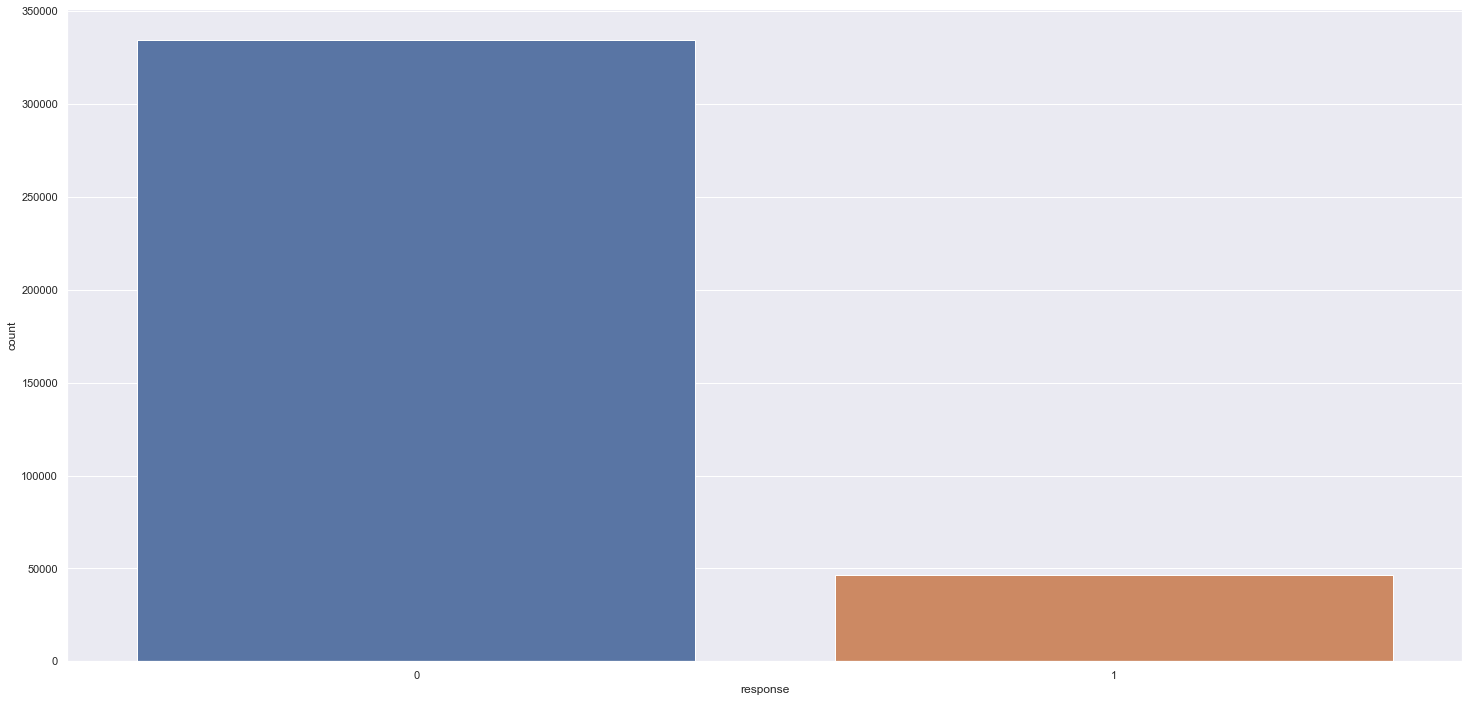

In [74]:
sns.countplot(df3['response']);

### 3.1.2 NUMERICAL VARIABLES

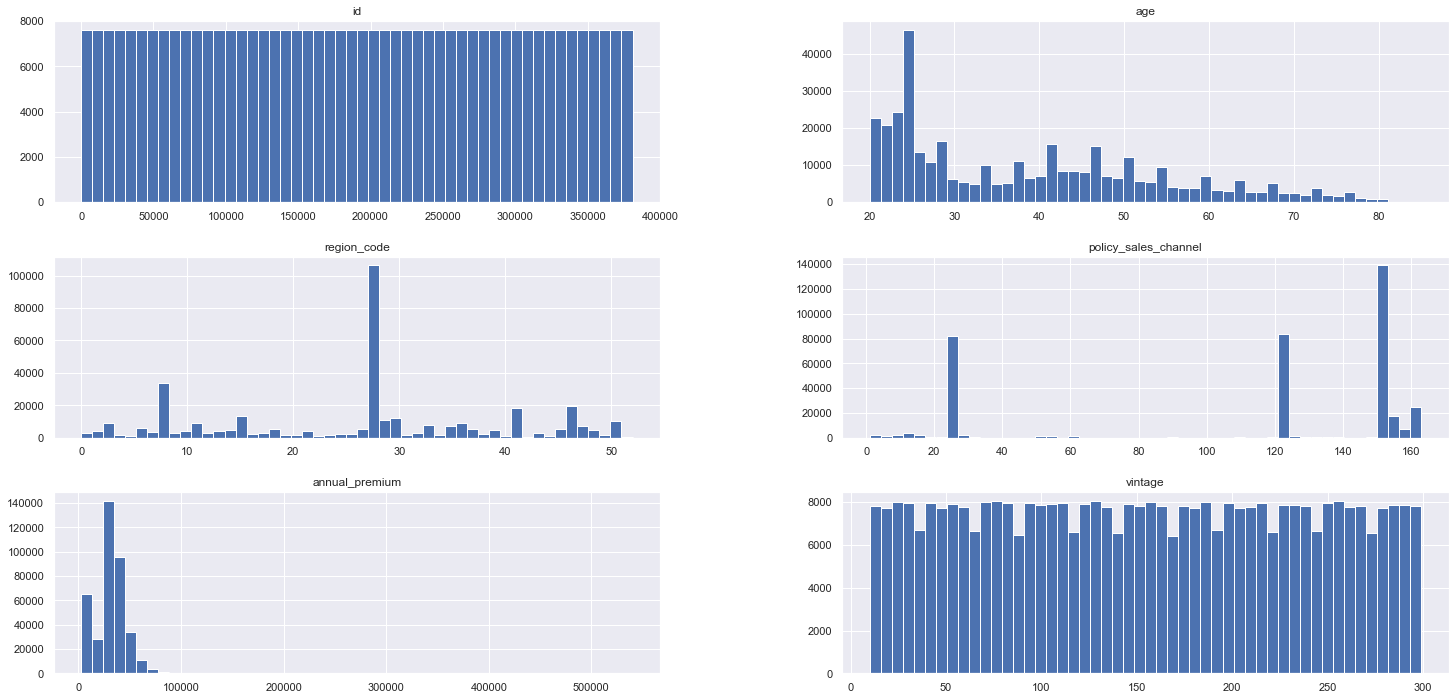

In [122]:
num_attributes.hist(bins=50);

### 3.1.3 CATEGORICAL VARIABLES

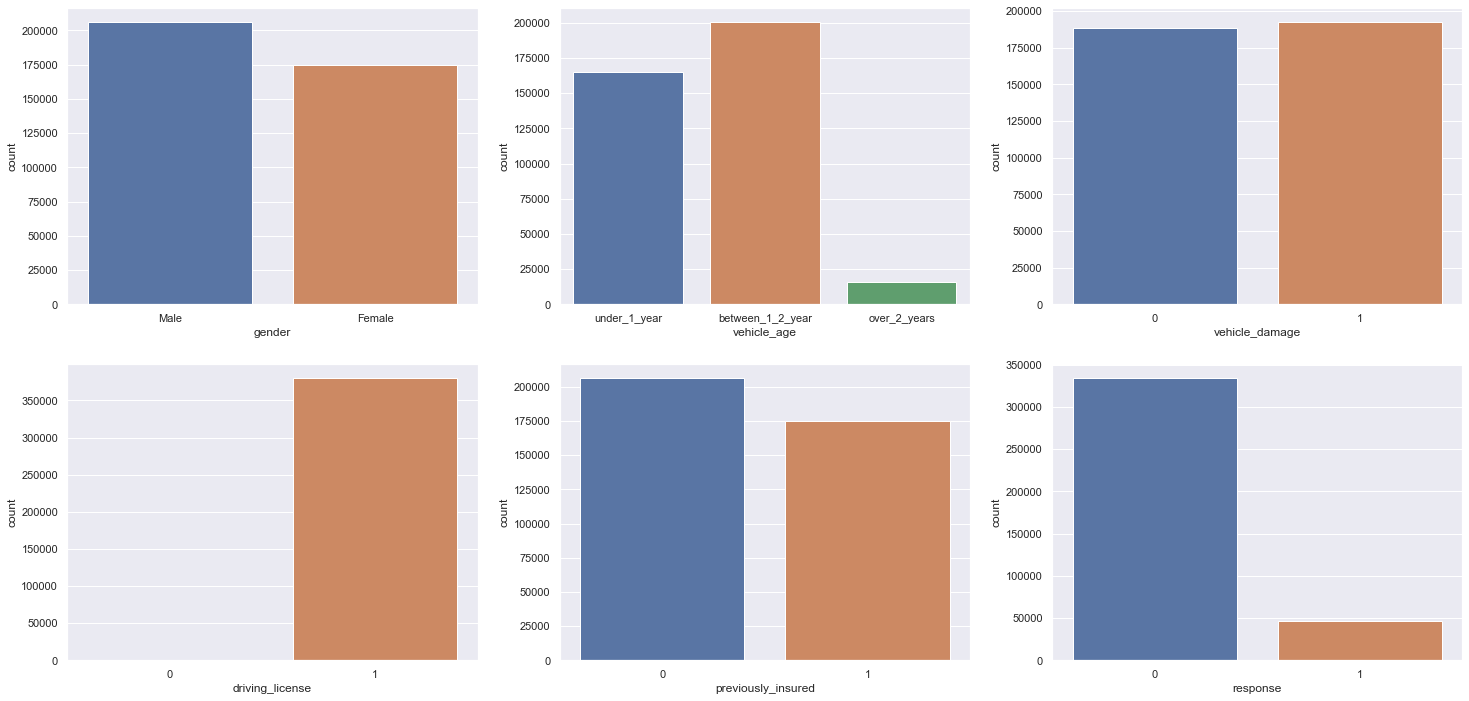

In [123]:
plt.subplot(2,3,1)
sns.countplot(cat_attributes['gender']);
plt.subplot(2,3,2)
ordering = ['under_1_year','between_1_2_year','over_2_years']
sns.countplot(cat_attributes['vehicle_age'],order=ordering);
plt.subplot(2,3,3)
sns.countplot(cat_attributes['vehicle_damage']);
plt.subplot(2,3,4)
sns.countplot(cat_attributes['driving_license']);
plt.subplot(2,3,5)
sns.countplot(cat_attributes['previously_insured']);
plt.subplot(2,3,6)
sns.countplot(cat_attributes['response']);

## 3.2 BIVARIATE ANALYSIS

In [169]:
aux32 = df3[df3['response']==1]

(46710, 12)

### 1. Older people will be more interested.

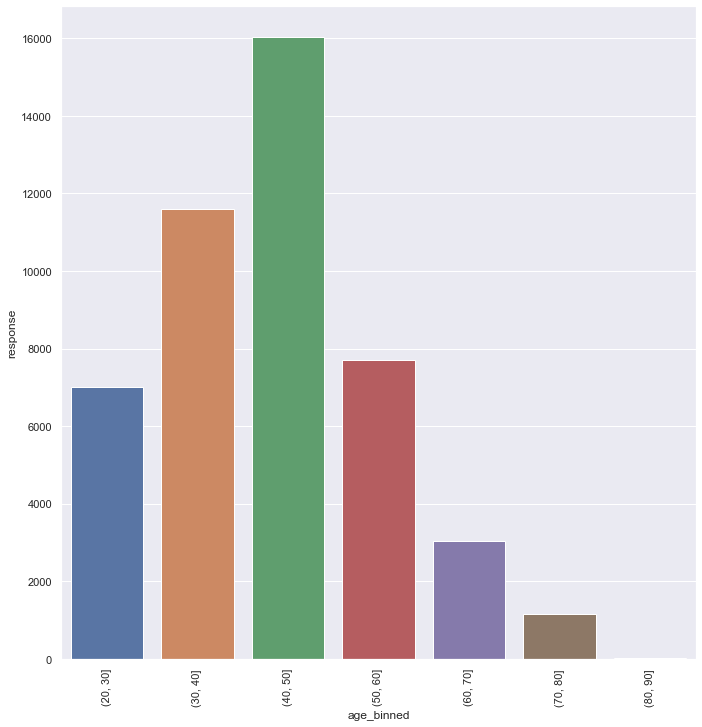

In [167]:
h1 = aux32[['age','response']].groupby('age').count().reset_index()

plt.subplot(1,2,1)
bins = list(np.arange(20,91,10))

h1['age_binned'] = pd.cut(h1['age'],bins=bins)
h12 = h1[['age_binned','response']].groupby('age_binned').sum().reset_index()
sns.barplot(x='age_binned',y='response',data=h12);
plt.xticks(rotation=90);
